**Liens du challenge :**

https://challengedata.ens.fr/participants/challenges/140/

**Contexte:**

Dans le cadre de l’activité de valorisation de l’énergie sur les marchés de l’électricité, Elmy aimerait disposer d’un modèle de prévision permettant de juger en amont si les prix de l’électricité sur le marché SPOT (marché d’enchère européen permettant d’acheter de l’électricité la veille pour le lendemain) seront plus ou moins élevés que les prix de l’électricité sur le marché Intraday (marché boursier européen permettant d’acheter de l’électricité le jour même).

**But:**

L’exercice consiste en la modélisation supervisée de l'écart de prix entre le marché infra-journalier (dit "Intraday") et le marché SPOT. L'écart de prix peut être modélisé par une régression mais aussi par une classification car ce qui importe avant tout est de prédire correctement le sens de cet écart (si tel ou tel prix sera supérieur ou inférieur à l’autre).

**Description des données:**

Index

*   *DELIVERY_START* : date et heure de livraison de l'électricité


Variables explicatives

* *load_forecast* : prévision de consommation totale d'éléctricité en France
* *coal_power_available*, *gas_power_available*, *nucelear_power_available* : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,
* *wind_power_forecasts_average*, *solar_power_forecasts_average* : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),
* *wind_power_forecasts_std*, *solar_power_forecasts_std* : écart-type de ces mêmes prévisions,
* *predicted_spot_price* : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.

Variable cible

* *spot_id_delta* : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

**Description du benchmark**

Un benchmark simple consiste à prédire que les prix sur le marché Intraday sortiront toujours plus haut que les prix sur le marché SPOT. C'est à dire que les valeurs prédites seront toujours positives. On observe en effet que, historiquement, les prix sur le marché intraday sortent un peu plus souvent au dessus des prix au SPOT.

**Métrique d'évaluation des performances du modèle**

Puisque l'objectif est avant de tout de prédire correctement le sens de l'écart, on s'appuyera sur une métrique de classification pour évaluer la performance d'un modèle. La grandeur de l'écart observé nous importe aussi : plus l'écart observé est important, plus il est important de prédire le correctement son sens. La métrique de performance proposée pour ce challenge est donc la Weighted Accuracy. C'est à dire la proprotion des predictions dont les sens (positif ou négatif) est correctement identifié pondérée par la valeur absolue des écarts réellement observés.

In [1]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Chemin de base pour tous vos fichiers de données
folder_path = '/content/drive/My Drive/Colab Notebooks/Projet_ML/datas'

# Chemins spécifiques vers les fichiers en utilisant folder_path
path_train = f'{folder_path}/X_train.csv'
path_test = f'{folder_path}/X_test.csv'
path_y_train = f'{folder_path}/y_train.csv'
path_y_random = f'{folder_path}/y_random.csv'

# Chargement des données
X_train = pd.read_csv(path_train)
X_test = pd.read_csv(path_test)
y_train = pd.read_csv(path_y_train)
y_random = pd.read_csv(path_y_random)

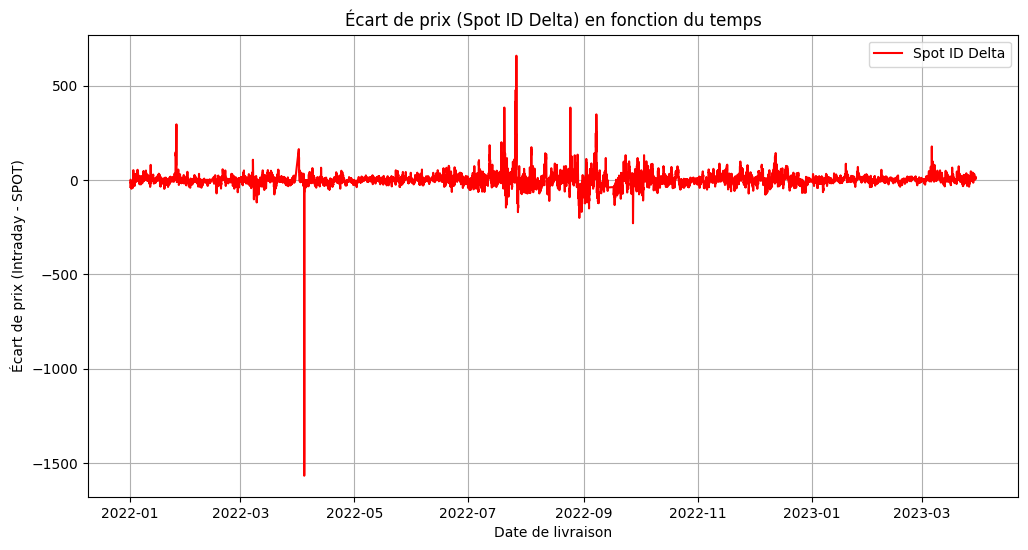

In [ ]:
# Assurez-vous que 'DELIVERY_START' est au format datetime
y_train['DELIVERY_START'] = pd.to_datetime(y_train['DELIVERY_START'])

# Trier les données par date
y_train.sort_values('DELIVERY_START', inplace=True)

# Créer le graphique
plt.figure(figsize=(12, 6))
plt.plot(y_train['DELIVERY_START'], y_train['spot_id_delta'], label='Spot ID Delta', color='red')
plt.title('Écart de prix (Spot ID Delta) en fonction du temps')
plt.xlabel('Date de livraison')
plt.ylabel('Écart de prix (Intraday - SPOT)')
plt.legend()
plt.grid(True)

plt.show()

Valeur maximale de spot_id_delta: 658.9613293687667
Valeur minimale de spot_id_delta: -1567.35354675402


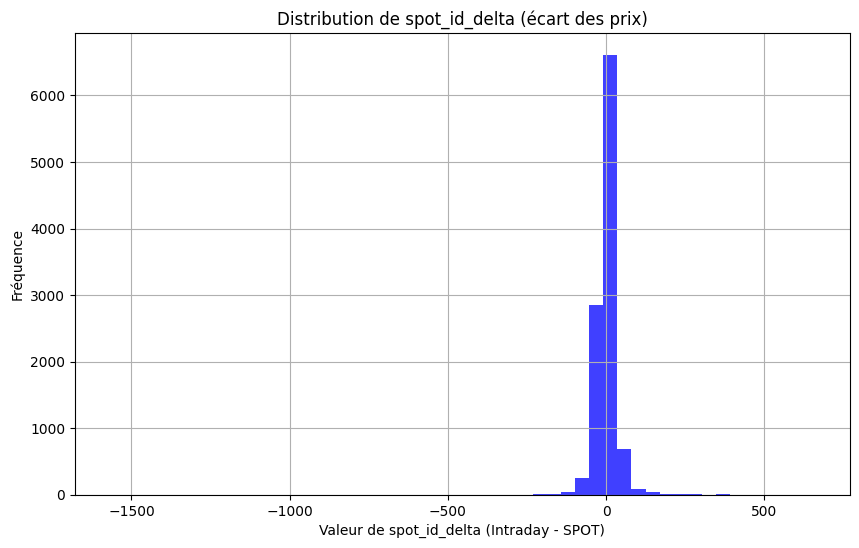

In [ ]:
# Affichage de la valeur maximale dans y_train pour la colonne 'spot_id_delta'
print("Valeur maximale de spot_id_delta:", y_train['spot_id_delta'].max())

# Affichage de la valeur minimale dans y_train pour la colonne 'spot_id_delta'
print("Valeur minimale de spot_id_delta:", y_train['spot_id_delta'].min())


# Histogramme de spot_id_delta
plt.figure(figsize=(10, 6))
plt.hist(y_train['spot_id_delta'].dropna(), bins=50, alpha=0.75, color='blue')
plt.title('Distribution de spot_id_delta (écart des prix)')
plt.xlabel('Valeur de spot_id_delta (Intraday - SPOT)')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

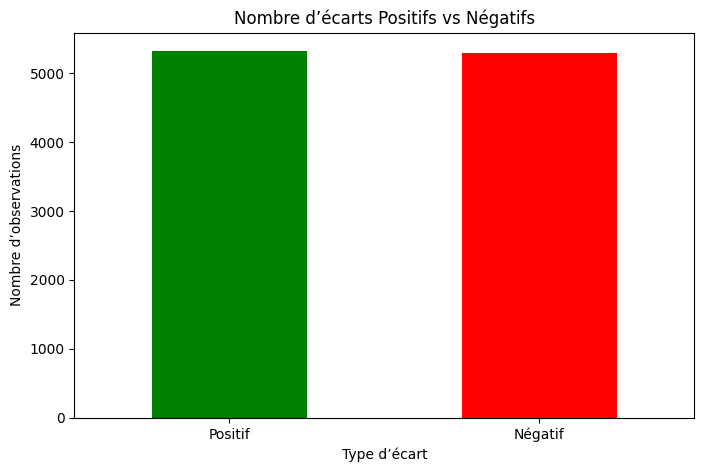

Nombre d'écarts positifs: 5320
Nombre d'écarts négatifs: 5285


In [ ]:
# Création d'une nouvelle colonne pour catégoriser les écarts comme 'Positif' ou 'Négatif'
y_train['Écart Type'] = y_train['spot_id_delta'].apply(lambda x: 'Positif' if x > 0 else 'Négatif')

# Diagramme à barres des écarts positifs et négatifs
plt.figure(figsize=(8, 5))
y_train['Écart Type'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Nombre d’écarts Positifs vs Négatifs')
plt.xlabel('Type d’écart')
plt.ylabel('Nombre d’observations')
plt.xticks(rotation=0)
plt.show()

# Calculer et imprimer le nombre exact d'écarts positifs et négatifs
ecart_counts = y_train['Écart Type'].value_counts()
print("Nombre d'écarts positifs:", ecart_counts['Positif'])
print("Nombre d'écarts négatifs:", ecart_counts['Négatif'])

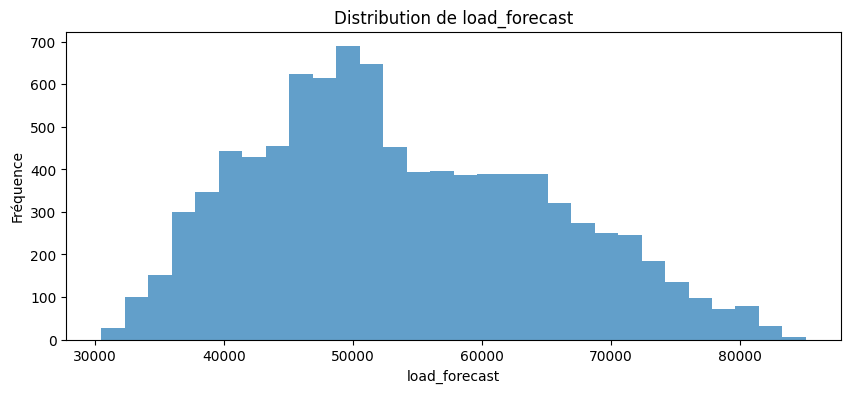

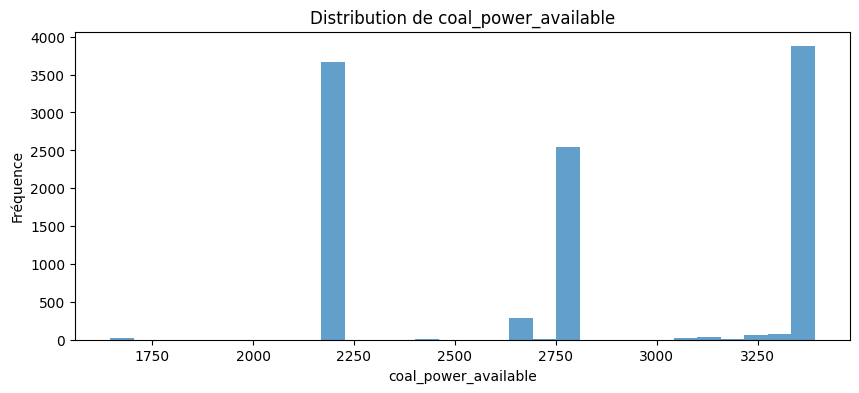

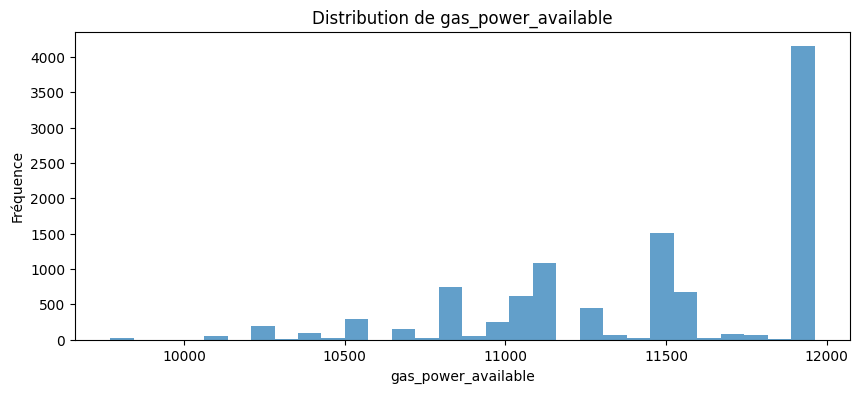

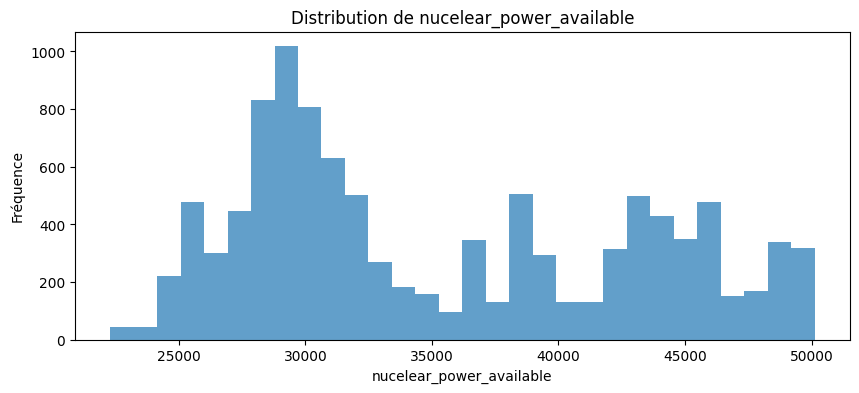

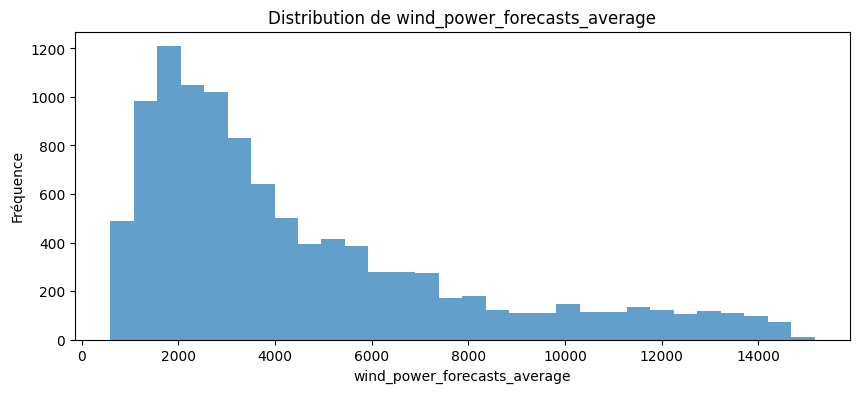

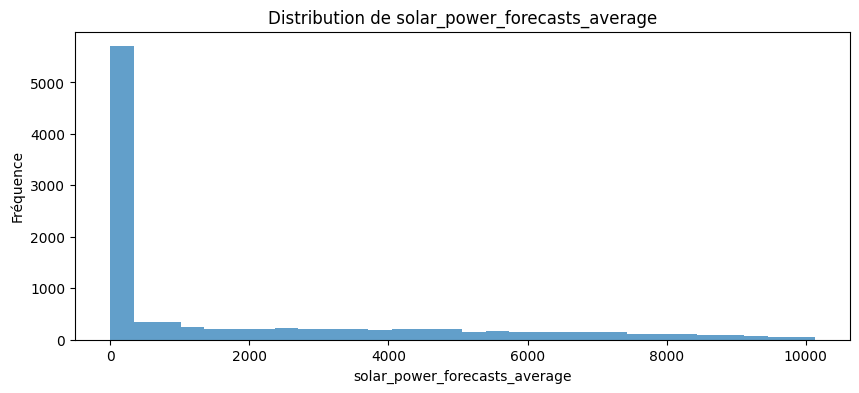

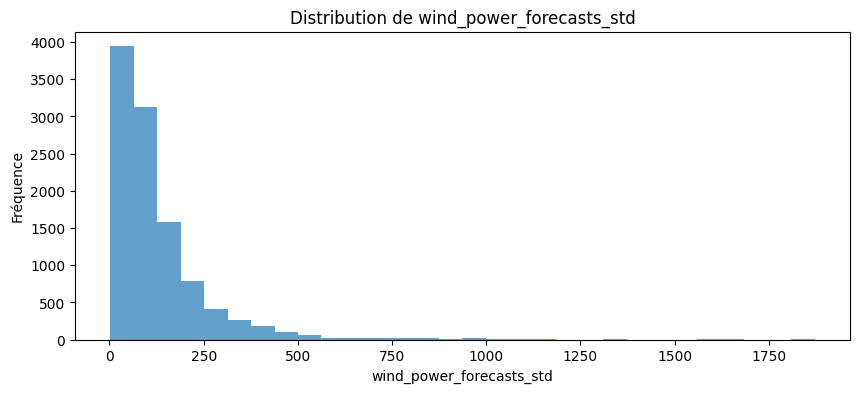

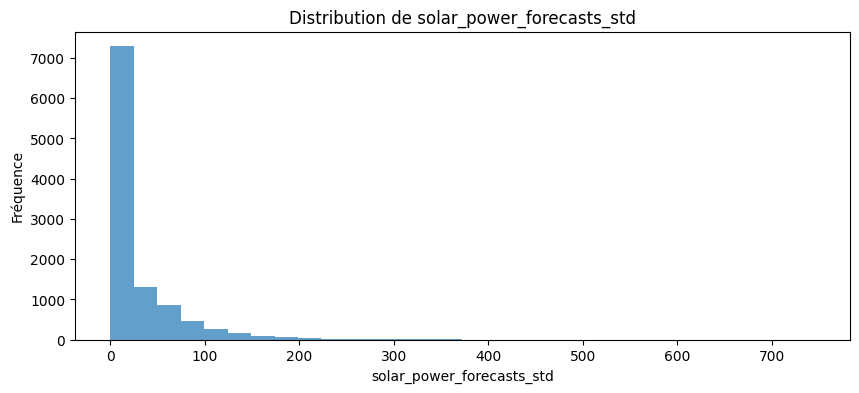

In [ ]:
# Liste des variables numériques (ajustez cette liste selon vos variables)
numeric_vars = ['load_forecast', 'coal_power_available', 'gas_power_available', 'nucelear_power_available', 'wind_power_forecasts_average', 'solar_power_forecasts_average', 'wind_power_forecasts_std', 'solar_power_forecasts_std']

# Créer des histogrammes pour les variables numériques
for var in numeric_vars:
    plt.figure(figsize=(10, 4))
    plt.hist(X_train[var].dropna(), bins=30, alpha=0.7)
    plt.title(f'Distribution de {var}')
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    plt.show()


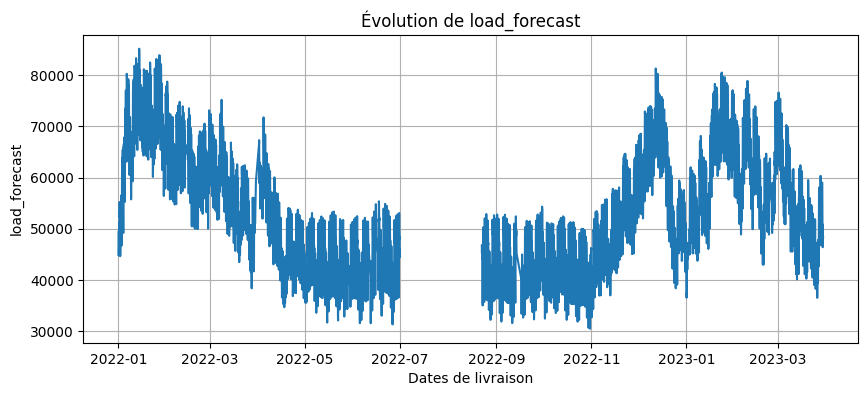

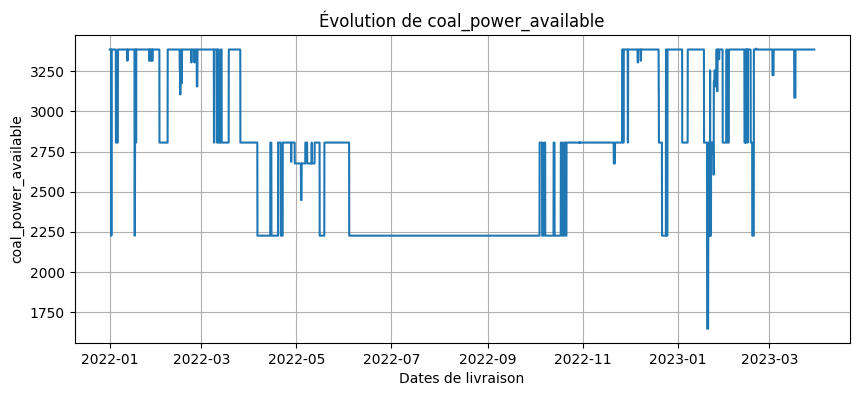

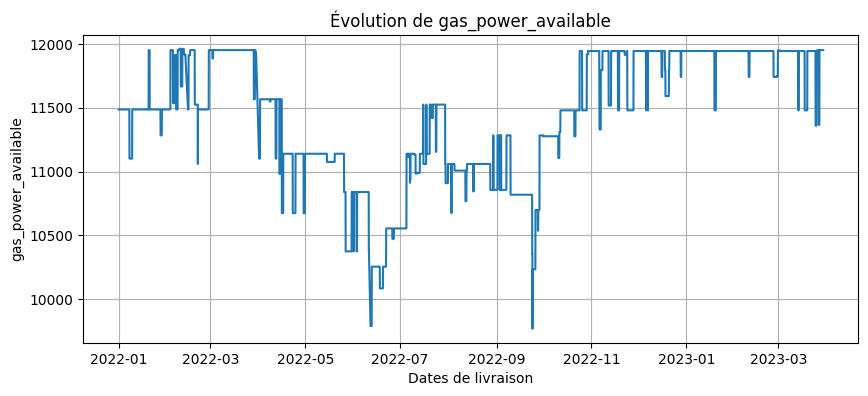

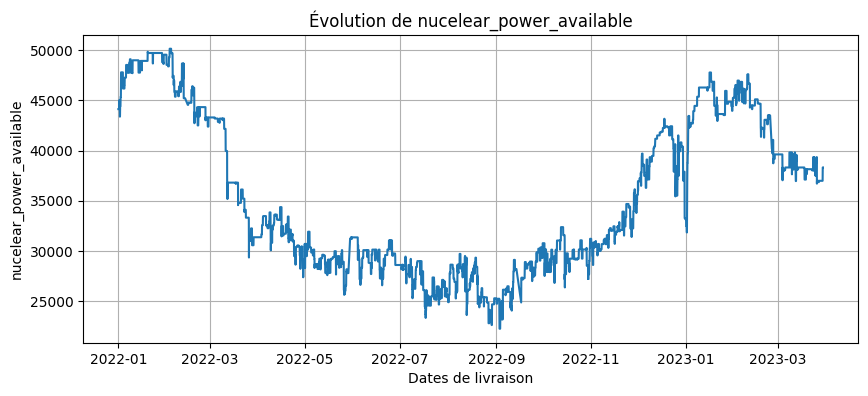

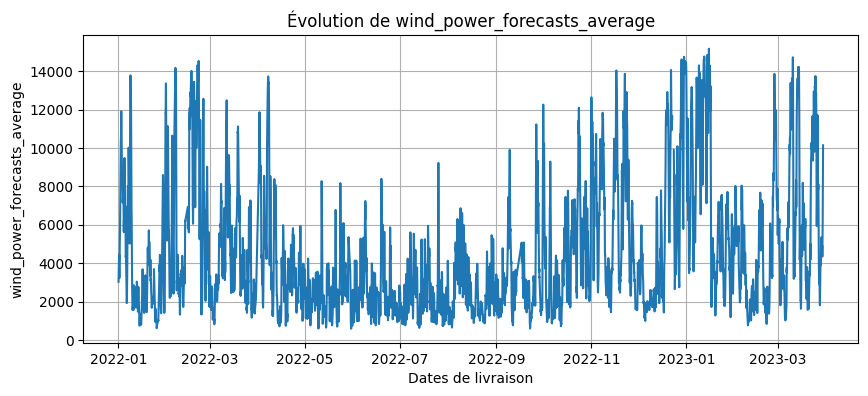

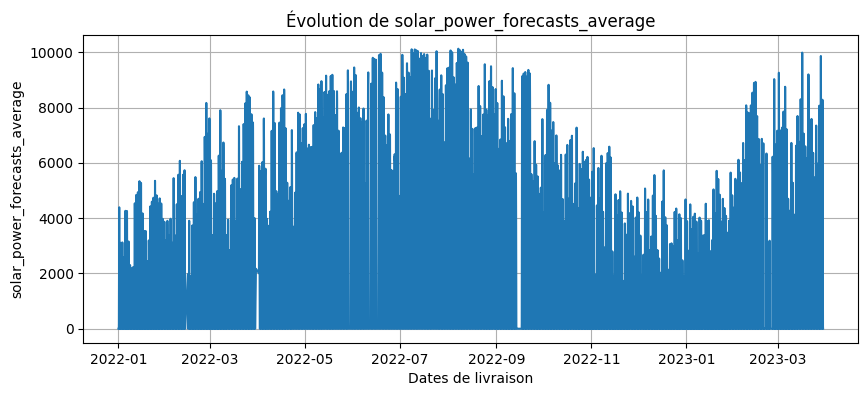

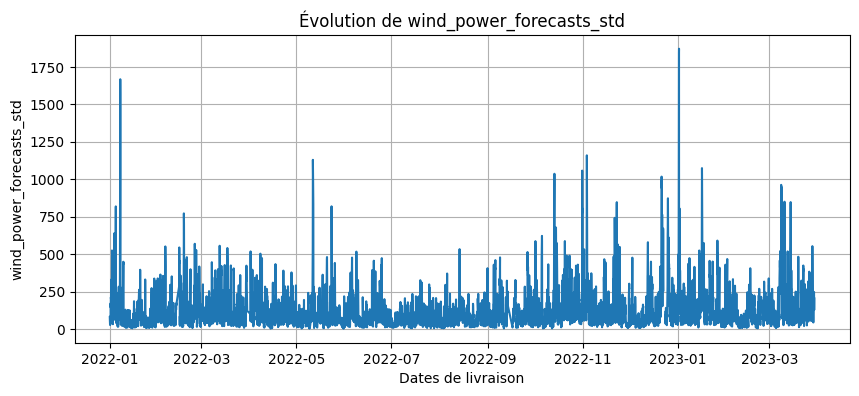

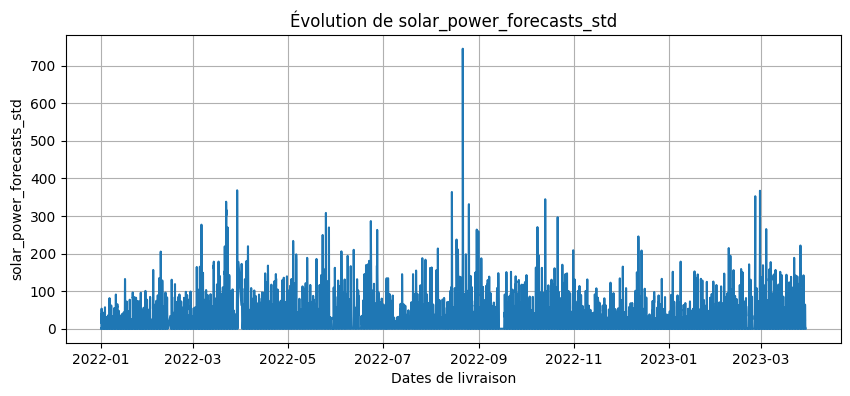

In [ ]:
# Créer des histogrammes pour les variables numériques
X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'])

for var in numeric_vars:
    plt.figure(figsize=(10, 4))
    plt.plot(X_train['DELIVERY_START'], X_train[var])
    plt.title(f'Évolution de {var}')
    plt.xlabel('Dates de livraison')
    plt.ylabel(var)
    plt.grid(True)
    plt.show()

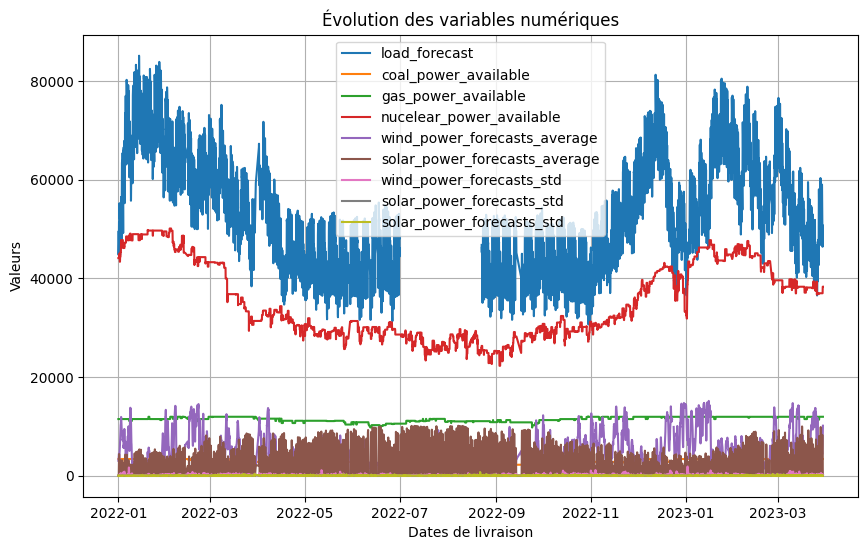

In [ ]:
# Créer une nouvelle figure en dehors de la boucle
plt.figure(figsize=(10, 6))

# Supposons que numeric_vars contient les noms des colonnes numériques que vous souhaitez visualiser
for var in numeric_vars:
    plt.plot(X_train['DELIVERY_START'], X_train[var], label=var)  # Tracez chaque graphique avec un label spécifique

plt.plot(X_train['DELIVERY_START'], X_train[var], label=var)
# Définir les titres, les étiquettes des axes, et activer la grille
plt.title('Évolution des variables numériques')
plt.xlabel('Dates de livraison')
plt.ylabel('Valeurs')
plt.grid(True)

# Ajouter une légende pour identifier chaque variable
plt.legend()

# Afficher le graphique
plt.show()

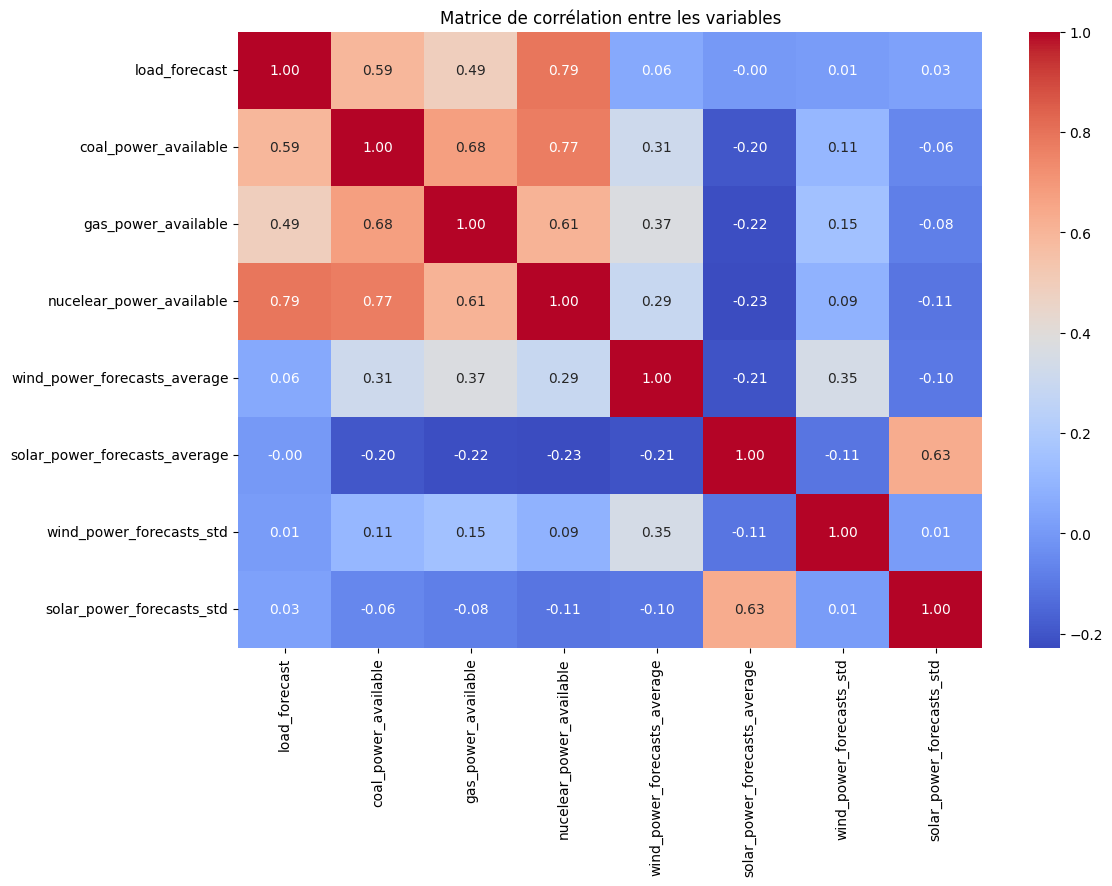

In [ ]:
# Matrice de corrélation
corr_matrix = X_train[numeric_vars].corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation entre les variables')
plt.show()
